# Demo notebook showing arbok functionalities

This is a simple demo notebook containing the core functionalities of arbok

### Importing qm and arbok module

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.simulate.credentials import create_credentials
from qm import SimulationConfig

2023-07-18 17:01:47,445 - qm - INFO     - Starting session: bc0d0de9-45e9-4113-9569-b474ce232865


In [2]:
from arbok.core.sequence import Sequence
from arbok.core.sample import Sample

from arbok.samples.sunshine.readout.other_ST_read import OtherStReadout
from arbok.samples.sunshine.initialization.mixed_down_up_init import (
    MixedDownUpInit
)
from arbok.samples.sunshine.control.smart_Y import SmartY
from arbok.samples.sunshine.control.smart_swap import SmartSwap
from arbok.samples.sunshine.control.dummy_control import Square
from arbok.samples.sunshine.configs.rf2v_config import rf2v_config

### Instanciating Arbok modules

Firstly we instanciate all `Sequence` objects that should build the entire 
measurement. Since we imported all sequences from the 'arbok.samples.sunshine' 
they already have the config for that specific sample

In [3]:
smart_Y = SmartY('smartY')
smart_swap12 = SmartSwap('smartSwap12')
smart_swap23 = SmartSwap('smartSwap32')
square = Square('square')
duInit = MixedDownUpInit('duInit')
stReadout = OtherStReadout('stReadout')

Next we create an empty `Sequence` class we call 'MEAS' that will structure all 
subsequeces. This time we need to pass a `Sample` since its a unconfigured 
sequence. We create second empty sequence to summarize all control sequences 
(everything happening before readout and after initialization). This is not
mandatory but is helpfull if you want to simulate the entire qubit control part
of the experiment.

In [4]:
sunshine = Sample('sunshine', rf2v_config)

In [5]:
MEAS = Sequence('MEAS', sample = sunshine)
CYY = Sequence('CYY', sample = sunshine)

Thus we add all sub-sequences responsible for qubit control in 'CYY' ...

In [6]:
CYY.add_subsequence(smart_swap12)
CYY.add_subsequence(smart_Y)
CYY.add_subsequence(smart_swap23)

... and finally add initialization, control and readout to the summarizing 
`Sequence`. 

In [7]:
MEAS.add_subsequence(duInit)
MEAS.add_subsequence(CYY)
MEAS.add_subsequence(square)
MEAS.add_subsequence(stReadout)

Note that the QCoDeS `Parameter`s describing the respective sub sequenes are 
saved within their sub classes. The QUA code lives within the sub classes as well
and gets compiled recursively, once we call `get_program()` on the class itself
or on any of its parent sequences. See in the cell below how to access parameters.

In [8]:
MEAS.CYY.smartSwap12.tSwap.get()

4

In [9]:
MEAS.stReadout.vPreRead_P1.get()

0.13

In [10]:
MEAS.CYY.submodules

{'smartSwap12': <SmartSwap: smartSwap12>,
 'smartY': <SmartY: smartY>,
 'smartSwap32': <SmartSwap: smartSwap32>}

In [11]:
MEAS.CYY.smartSwap12.root_instrument

<Sequence: MEAS>

### Simulating Sequences

The entire sequence, any sub group or any sub sequence can now be simulated by
calling `run_remote_simulation` with the desired simulation duration in cycles 
(4ns/cycle). Simulating $\sqrt{SWAP}$ ...

2023-07-18 17:01:50,390 - qm - INFO     - Performing health check
2023-07-18 17:01:51,192 - qm - INFO     - Health check passed
2023-07-18 17:01:51,770 - qm - INFO     - Simulating program


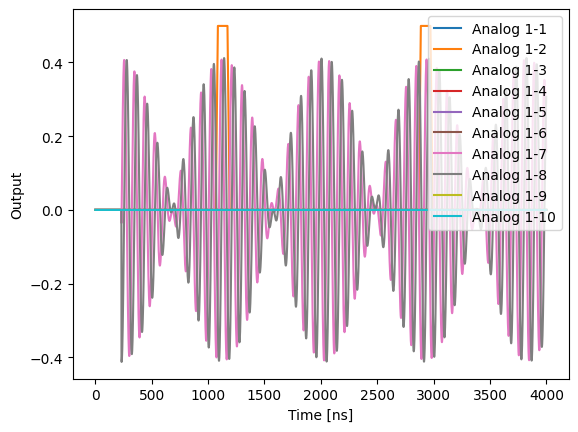

In [12]:
job = MEAS.CYY.smartSwap12.run_remote_simulation(duration = 1000)

... and the entire $CYY$-gate:

2023-07-18 17:01:58,076 - qm - INFO     - Performing health check
2023-07-18 17:01:58,878 - qm - INFO     - Health check passed
2023-07-18 17:01:59,470 - qm - INFO     - Simulating program


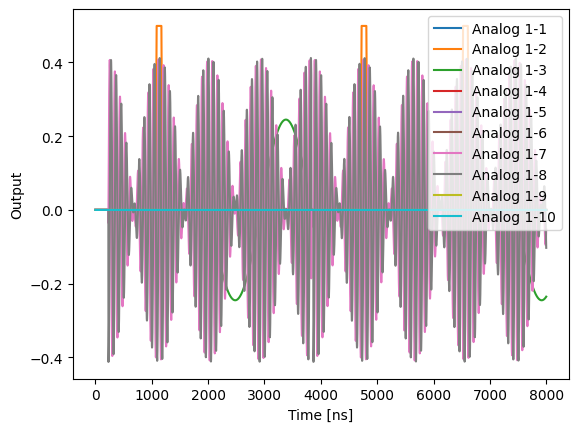

In [13]:
MEAS.CYY.smartY.smart_cycles(1)
job = MEAS.CYY.run_remote_simulation(duration = 2000)

### Parameter sweeps

Next, we demonstrate parameter sweeps within the QUA script. Choose a `sequence`
you want to simulate and pass a list of QCoDeS parameters you want to sweep, as
well as a numpy array for each of those parameters. The last parameter in the
list corresponds to the innermost loop of the sweep. In the following we only
simulate $\sqrt{SWAP}$ gate while sweeping the delay and duration of the swap
pulse.

In [14]:
MEAS.square.settables = [MEAS.square.amp, MEAS.square.tSquare]
MEAS.square.setpoints_grid = [ np.linspace(0.1, 1, 3), np.linspace(4, 50, 3) ]

2023-07-18 17:02:06,111 - qm - INFO     - Performing health check
2023-07-18 17:02:06,911 - qm - INFO     - Health check passed
2023-07-18 17:02:07,488 - qm - INFO     - Simulating program


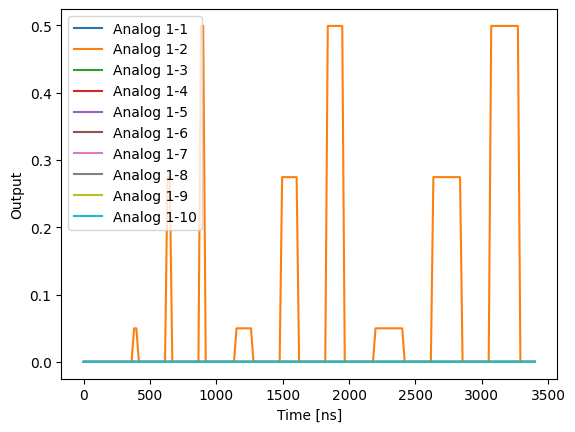

In [15]:
job = MEAS.square.run_remote_simulation(duration = 850)

We can simulate the same parameter sweep for the summarizing `Sequence` 'CYY' as
well, for example to see how pulses align for previous or following sequences.
To do that, we have to add `settables` and the `setpoints_grid` to the sequence
we want to simulate.

In [16]:
MEAS.CYY.settables = [MEAS.CYY.smartSwap12.vControlSWAP_J1, MEAS.CYY.smartSwap12.tSwap]
MEAS.CYY.setpoints_grid = [ np.linspace(0.5, 1, 3), np.linspace(4, 100, 3) ]
MEAS.CYY.smartSwap12.vControlSWAP_J1.batched = True
MEAS.CYY.smartSwap12.tSwap.batched = True
MEAS.CYY.smartY.smart_cycles(1)

2023-07-18 17:02:13,803 - qm - INFO     - Performing health check
2023-07-18 17:02:14,606 - qm - INFO     - Health check passed
2023-07-18 17:02:15,229 - qm - INFO     - Simulating program


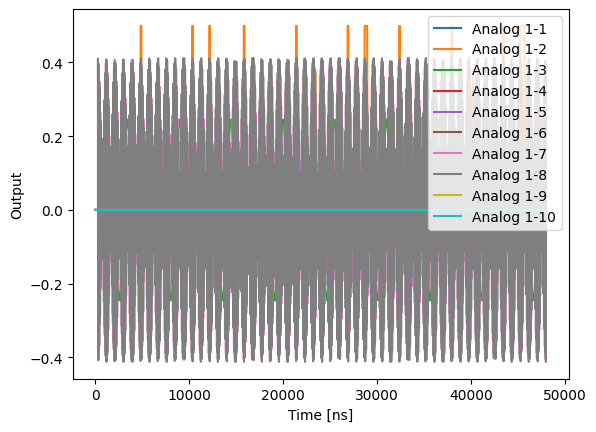

In [17]:
job = MEAS.CYY.run_remote_simulation(duration = 12000)

### Simulating readouts

2023-07-18 17:02:25,073 - qm - INFO     - Performing health check
2023-07-18 17:02:25,873 - qm - INFO     - Health check passed
STREAMING
2023-07-18 17:02:26,655 - qm - INFO     - Simulating program


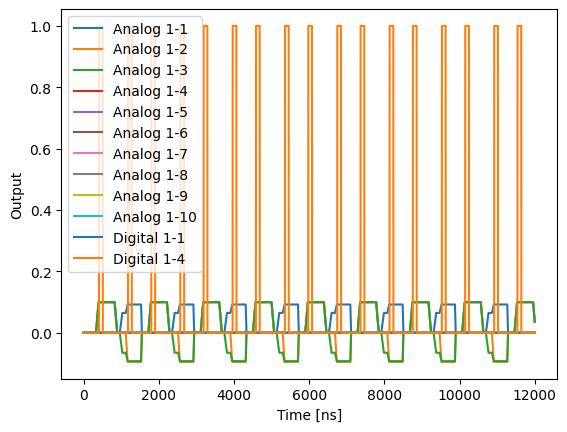

In [18]:
MEAS.CYY.smartSwap12.tWait(int(192))
#job = MEAS.CYY.smartSwap12.run_remote_simulation(duration = 2000)
job = MEAS.stReadout.run_remote_simulation(duration = 3000)

In [19]:
samples = job.get_simulated_samples()

In [20]:
job.result_handles.__dict__

{'_job_id': '1689321258535',
 '_service': <qm.api.job_result_api.JobResultServiceApi at 0x1ec78271190>,
 '_store': <qm.persistence.SimpleFileStore at 0x1ec78260590>,
 '_schema': JobResultSchema(items={'ref2_read_I': JobResultItemSchema(name='ref2_read_I', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_read_Q': JobResultItemSchema(name='ref2_read_Q', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_read': JobResultItemSchema(name='ref2_read', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_chopRef': JobResultItemSchema(name='ref2_chopRef', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), 'ref2_state': JobResultItemSchema(name='ref2_state', dtype=[['value', 'bool8']], shape=(1,), is_single=False, expected_count=-1), 'read_read_I': JobResultItemSchema(name='read_read_I', dtype=[['value', 'float64']], shape=(1,), is_single=False, expected_count=-1), '

In [21]:
job.result_handles.diff_state.fetch_all()['value']

array([False, False, False, False, False, False, False, False])

### Using the `Sequence` in the quantify-core library

In [22]:
import quantify_core.data.handling as dh
from quantify_core.measurement import MeasurementControl

In [23]:
dh.set_datadir(dh.default_datadir())

Data will be saved in:
C:\Users\z5440260\quantify-data


In [24]:
meas_ctrl = MeasurementControl('meas_ctrl')

In [25]:
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [26]:
# plotmon = pqm.PlotMonitor_pyqt("plotmon")
# insmon = InstrumentMonitor("InstrumentMonitor")
# meas_ctrl.instr_plotmon(plotmon.name)

In [27]:
import datetime

MEAS.stReadout.add_parameter(
    name = 'dummy_read',
    unit = '',
    get_cmd = lambda: np.cos(datetime.datetime.now().microsecond*1e-4)
)

In [28]:
meas_ctrl.settables([
    MEAS.CYY.smartSwap12.tWait, 
    MEAS.CYY.smartSwap12.vControlSWAP_J1
])
meas_ctrl.setpoints_grid([
    range(180,220), 
    range(4,2000)
])

meas_ctrl.gettables(MEAS.stReadout.dummy_read)
#dset = meas_ctrl.run(name="Frequency sweep")

Gettables need to be `ParameterWithSetpoints`. This takes an arbitrary amount of 1D setpoint arrays (sizes (n), (m), (k)) and returns (n,m,k) get array.

In [29]:
#meas_ctrl.run()

Note that 'tInitLoadMixed' and 'tPreControl' have been reduced for the sake of visibility.